In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_5/recommendationsv4/'
DIR_TEST = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_5/TEST/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
#Читаем файлы
data = pd.read_csv(DIR + 'train.csv',low_memory=False )
test = pd.read_csv(DIR +'test.csv',low_memory=False )

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [6]:
data.describe()

,overall,unixReviewTime,userid,itemid,rating
count,857895.000000,8.578950e+05,857895.000000,857895.000000,857895.000000
mean,4.441695,1.441755e+09,54573.200856,17080.473226,0.848927
std,1.064655,5.973571e+07,36799.421892,11441.176435,0.358120
min,1.000000,9.657792e+08,0.000000,0.000000,0.000000
25%,4.000000,1.411949e+09,21949.000000,6329.000000,1.000000
50%,5.000000,1.449101e+09,50015.000000,15935.000000,1.000000
75%,5.000000,1.484870e+09,85024.000000,26616.000000,1.000000
max,5.000000,1.538438e+09,127495.000000,41319.000000,1.000000


In [7]:
data.head()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


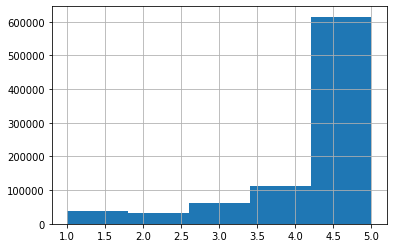

In [8]:
data.overall.hist( bins = 5 )

Большинство оценок - положительные, даже превосходные. Отрицательных оценок не более 25 %. выборка несбалансированная

In [9]:
data['verified'].value_counts(normalize=True) *100

True     86.868789
False    13.131211
Name: verified, dtype: float64

Неверифицированных отзывов около 13% Посмотрим оценки этих отзывов

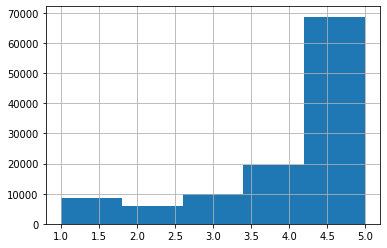

In [10]:
data[data['verified']== False].overall.hist( bins = 5 )

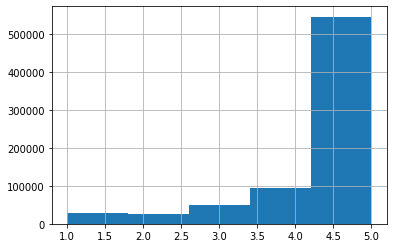

In [11]:
data[data['verified']== True].overall.hist( bins = 5 )

Графики распределений оценок для верифицированных и неверифицированных отзывов похожи, но есть небольшой перекос в сторону отрицательных оценок у неверифицированных отзывов

In [12]:
data[data['verified']== True]['overall'].value_counts(normalize=True) *100

5.0    73.329505
4.0    12.575898
3.0     6.763432
1.0     3.873636
2.0     3.457530
Name: overall, dtype: float64

In [13]:
data[data['verified']== False]['overall'].value_counts(normalize=True) *100

5.0    60.995810
4.0    17.197209
3.0     8.908852
1.0     7.660761
2.0     5.237368
Name: overall, dtype: float64

Проверяем правильно ли заполнено поле rating - все в порядке

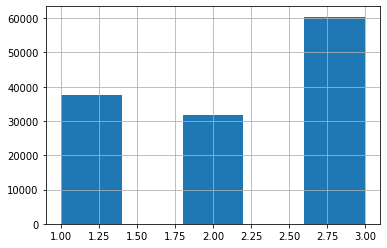

In [14]:
data[data['rating'] == 0].overall.hist( bins = 5 )

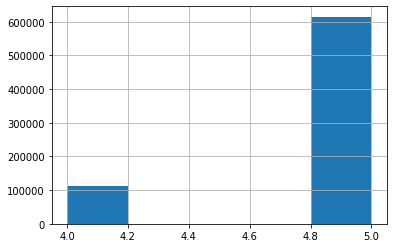

In [15]:
data[data['rating'] == 1].overall.hist( bins = 5 )

In [16]:
len(data.userid.unique()), len(data.itemid.unique())

(127448, 41302)

Отзывы сделало 127 448 пользователей, оценено 41 302 продуктов

In [17]:
#Количество записей в тренировочной , тестовой выборках, соотношение между ними
len(data), len(test),  len(test)/len(data)

(857895, 285965, 0.3333333333333333)

In [18]:
## Считаем пользователей по группам - те кто даёт только положительные оценки, только отрицательные и смешанные.

all_unique_users = data['userid'].nunique()
unique_happy_users = data[data['overall']>=4]['userid'].unique()
unique_unhappy_users = data[data['overall']<4]['userid'].unique()

n_always_happy_users = data[(data['overall']>=4)&(~data['userid'].isin(unique_unhappy_users))]['userid'].nunique()
n_always_unhappy_users = data[(data['overall']<4)&(~data['userid'].isin(unique_happy_users))]['userid'].nunique()
n_different_users = all_unique_users-n_always_happy_users-n_always_unhappy_users

(-1.1086567027289387,
 1.1004122535397851,
 -1.125262435890257,
 1.1103661647995344)

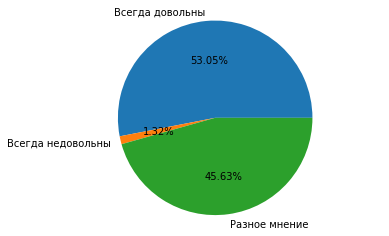

In [19]:
vals = [n_always_happy_users, n_always_unhappy_users, n_different_users]
labels = ["Всегда довольны", "Всегда недовольны", "Разное мнение"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.2f%%')
ax.axis("equal")

Чуть более половины уникальных пользователей всегда оставляют только положительные отзывы, пользователей, которые оставляют только отрицательные - крайне мало. Возможно стоит взвешивать оценки, снижая вес тем, кто только хвалит и добавляя пользователям с разным мнением. возможно часть из пользователей, которые только хвалят - это проплаченные отзывы, а не отзывы настоящих клиентов.
Посмотрим далее на распределение продуктов по тому же принципу.

In [20]:
## Считаем пользователей по группам - те кто даёт только положительные оценки, только отрицательные и смешанные.

all_unique_item = data['itemid'].nunique()
unique_good_item = data[data['overall']>=4]['itemid'].unique()
unique_bad_item = data[data['overall']<4]['itemid'].unique()

n_always_good_items = data[(data['overall']>=4)&(~data['itemid'].isin(unique_bad_item))]['itemid'].nunique()
n_always_bad_items = data[(data['overall']<4)&(~data['itemid'].isin(unique_good_item))]['itemid'].nunique()
n_different_items = all_unique_item - n_always_good_items - n_always_bad_items

(-1.1179423691079082,
 1.100854398528948,
 -1.1138083874386526,
 1.1119902252076268)

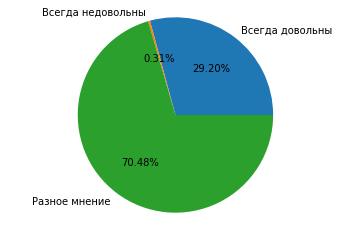

In [21]:
vals = [n_always_good_items, n_always_bad_items, n_different_items]
labels = ["Всегда довольны", "Всегда недовольны", "Разное мнение"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.2f%%')
ax.axis("equal")

Продукты, которыми все всегда довольны, составляют меньшую долю, чем всегда довольные пользователи, тем не менее их почти 30%, продуктов с всегда отрицательными оценками всего 0,30% - в сто раз меньше. по большей части продуктовой линейки мнение разделилось.
Возможно стоит поставить продукты с плохими отзывами в стоп-лист и никогда не рекоммендовать их пользователям (Или вообще исключить их из ассортимента магазина.)

In [22]:
data['reviewTime'] = data['reviewTime'].apply(lambda x: datetime.datetime.strptime(x, '%m %d, %Y') )
data['Year'] = data['reviewTime'].apply(lambda x : x.year)
data.loc[data['Year']<= 2013,['Year']] = '<2013'

(-1.1268711941674028,
 1.1012796044202544,
 -1.1110382647511108,
 1.1052457670653024)

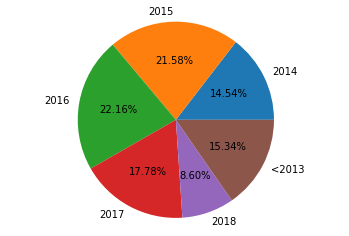

In [23]:
year_rew_count = data[['overall','Year']].groupby(['Year'], as_index = False).count()

    
vals = year_rew_count['overall']
labels = year_rew_count['Year']
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.2f%%')
ax.axis("equal")

Около половины отзывов оставлены за последние три года (если считать что данные свежие и сейчас 2018 год) Около 15% отзывов совсем старые и вероятно нерелевантны - им более 5 лет. Возможно стоит взвесить отзывы и увеличивать значимость более свежих по сравнению с более старыми.
Также возможно некоторые товары имеют сезонный спрос, но проверять мы это не будем, т.к. у нас нет легенды на то, какое сейчас время года)
Далее мы посмотрим продукты в разрезе годов рекоммендаций.

In [24]:
data['Year'] = data['reviewTime'].apply(lambda x : x.year)

unique_vold_item = data[data['Year']<=2013]['itemid'].unique()
unique_old_item = data[(data['Year']>2013)&(data['Year']<=2015)]['itemid'].unique()
unique_new_item = data[(data['Year']>2015)&(data['Year']<2018)]['itemid'].unique()
unique_vnew_item = data[(data['Year']==2018)]['itemid'].unique()


(-1.1128376054673832,
 1.1006113331435223,
 -1.1123739690294576,
 1.107676695554694)

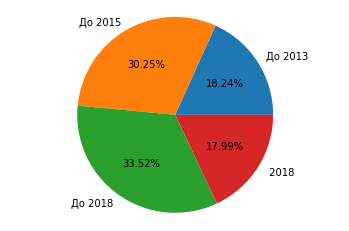

In [25]:
vals =[len(unique_vold_item), len(unique_old_item), len(unique_new_item), len(unique_vnew_item) ]
labels = ['До 2013', 'До 2015', 'До 2018', ' 2018']
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.2f%%')
ax.axis("equal")

Кол-во уникальных товаров по годам. как видно с 2016 по 2017 год в отзывах представлено наибольшее кол-во товаров. Вероятно следует исключать из выдачи товары, не представленные в отзывах с 2015 года (не факт что они вообще производятся, поставляются, есть в наличии)

In [26]:
### Оценим кол-во продуктов, по которым нет отзывов за последние 3 года

unique_notrelevant_item = data[(~data['itemid'].isin(unique_vnew_item))&(~data['itemid'].isin(unique_new_item))]['itemid'].unique()
print(len(unique_notrelevant_item))
print(len(unique_notrelevant_item)/all_unique_item)

6045
0.146360951043533


Таких целых 6 тысяч, почти 15% от всех продуктов. вероятно модель не должна выдавать рекоммендации на эти продукты.


Теперь посмотрим, часто ли пользователи меняют своё мнение о продукте. вероятно в таком случае стоит учитывать только последний отзыв. выборка очень большая по времени, могли измениться и технологии производства и вкусы клиента, да что угодно.

In [27]:
One_item_dif_rews = data.pivot_table(values = 'verified',
                                     index = ['itemid', 'userid'], 
                                     columns = 'overall', 
                                     aggfunc = 'count', 
                                     fill_value= 0, 
                                     margins = True ).reset_index()

One_item_dif_rews = One_item_dif_rews[One_item_dif_rews['All']>1]
print(len(One_item_dif_rews))

One_item_dif_rews['Positive'] = One_item_dif_rews[4.0]+One_item_dif_rews[5.0]
One_item_dif_rews['Negative'] = One_item_dif_rews['All'] - One_item_dif_rews['Positive']

print(len(One_item_dif_rews[(One_item_dif_rews['Positive']>0)&(One_item_dif_rews['Negative']>0)]))

41540
1452


41 тысяч раз клиенты оставляли несколько отзывов на продукт, но при этом из них только 1452 меняли своё мнение... Может это боты? посмотрим, сколько таким образом поставлено пятёрок.

In [28]:
One_item_dif_rews[(One_item_dif_rews[5.0]>1)&(One_item_dif_rews['itemid']!='All')][5.0].sum()

62364

Может следует эти записи  удалить, или учитывать с меньшим весом.